# DSC Donor Prediction

In [470]:
# Importing libraries
import sys
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
from pandas                 import DataFrame
from pandas                 import read_csv
from pandas                 import Series
from numpy                  import array
from numpy                  import random
from matplotlib             import pyplot
import warnings
warnings.filterwarnings("ignore")

import os
import datetime
from sklearn.metrics import roc_auc_score
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

# DATA PROCESSING

## CAMPAIGNS

In [471]:
#read in data
campaigns = pd.read_csv('../dsc_data/campaigns.csv', sep=";")
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [472]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


In [473]:
# Converting the date column to the datetime format
campaigns['CampaignDate'] = pd.to_datetime(campaigns['date'])

In [474]:
# Extracting the number from the CostUnit column and then converting to float
campaigns['CostUnitEuro'] = campaigns.CostUnit.str.extract('(\d+,\d+)')
campaigns['CostUnitEuro'] = campaigns['CostUnitEuro'].str.replace(',', '.').astype(float)

In [475]:
# Converting the lettersSent column to int type
campaigns['lettersSent'] = campaigns['lettersSent'].str.replace('\u202f', '').astype(int)

In [476]:
# drop unwanted columns
campaigns.drop(columns=['date', 'CostUnit'], inplace=True)

In [477]:
#extract Campaign year month and day from Campaigndate
campaigns['camp_year'] = pd.DatetimeIndex(campaigns['CampaignDate']).year
campaigns['camp_month'] = pd.DatetimeIndex(campaigns['CampaignDate']).month
campaigns['camp_day'] = pd.DatetimeIndex(campaigns['CampaignDate']).day

In [478]:
# cost per campaign calculation
campaigns['cost_per_campaign'] = campaigns['lettersSent']*campaigns['CostUnitEuro']

In [479]:
#checking for campaign 6169
campaigns[campaigns['campaignID']==6169]

,campaignID,lettersSent,CampaignDate,CostUnitEuro,camp_year,camp_month,camp_day,cost_per_campaign
335,6169,34888,2018-04-09,0.87,2018,4,9,30352.56


In [480]:
#checking for campaign 7244
campaigns[campaigns['campaignID']==7244]

,campaignID,lettersSent,CampaignDate,CostUnitEuro,camp_year,camp_month,camp_day,cost_per_campaign
354,7244,25645,2019-06-18,0.55,2019,6,18,14104.75


In [481]:
#checking for campaign values
campaigns.campaignID.unique()

array([ 153,  154,  180,  433,  476,  498,  536,  574,  584,  606,  627,
        663,  669,  711,  723,  767,  768,  796,  804,  816,  850,  858,
        899,  901,  930,  954,  968,  979,  980, 1000, 1026, 1028, 1034,
       1058, 1074, 1101, 1148, 1149, 1153, 1181, 1185, 1207, 1212, 1218,
       1235, 1245, 1248, 1280, 1316, 1317, 1331, 1338, 1343, 1374, 1377,
       1397, 1400, 1424, 1428, 1465, 1489, 1490, 1513, 1529, 1544, 1556,
       1568, 1577, 1601, 1615, 1626, 1634, 1636, 1663, 1664, 1678, 1698,
       1699, 1736, 1739, 1755, 1775, 1778, 1790, 1808, 1843, 1844, 1851,
       1861, 1875, 1878, 1903, 1904, 1917, 1929, 1933, 1949, 1962, 1966,
       1991, 1992, 2021, 2029, 2035, 2040, 2059, 2090, 2094, 2105, 2123,
       2129, 2133, 2144, 2163, 2193, 2194, 2224, 2225, 2231, 2232, 2233,
       2256, 2263, 2285, 2296, 2319, 2335, 2351, 2360, 2389, 2390, 2414,
       2415, 2416, 2417, 2451, 2470, 2485, 2498, 2534, 2550, 2553, 2566,
       2577, 2579, 2580, 2632, 2633, 2646, 2653, 26

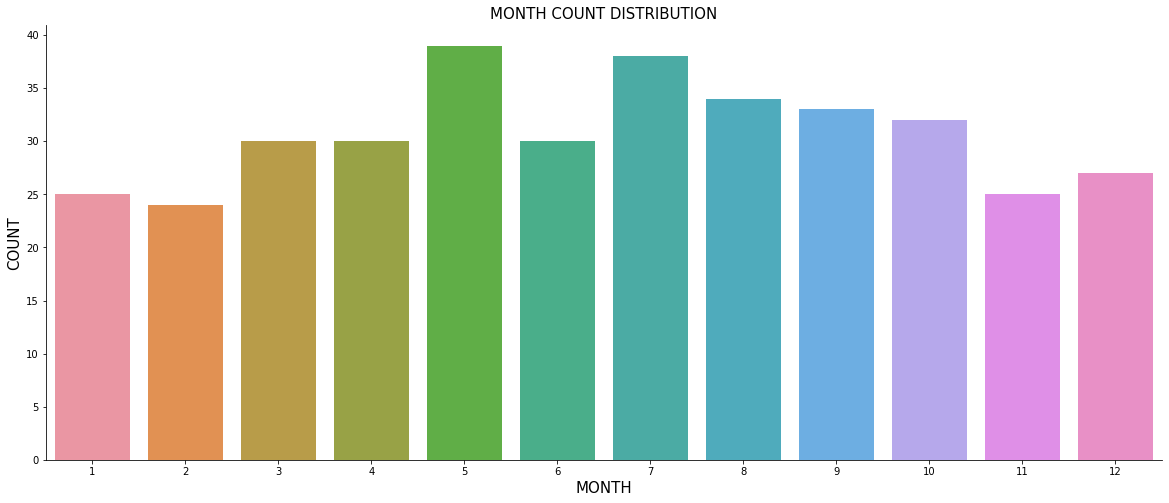

In [482]:
#visualization
cols_num = ['campaignID','lettersSent','CampaignDate','camp_year','camp_month','camp_day','cost_per_campaign']
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'camp_month', data =  campaigns[cols_num])
ax.set_xlabel('MONTH', fontsize=15)
ax.set_ylabel('COUNT', fontsize=15)
ax.set_title('MONTH COUNT DISTRIBUTION', fontsize=15)
sns.despine()

In [483]:
#checking the shape of the data
campaigns.shape

(367, 8)

In [484]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   campaignID         367 non-null    int64         
 1   lettersSent        367 non-null    int32         
 2   CampaignDate       367 non-null    datetime64[ns]
 3   CostUnitEuro       367 non-null    float64       
 4   camp_year          367 non-null    int64         
 5   camp_month         367 non-null    int64         
 6   camp_day           367 non-null    int64         
 7   cost_per_campaign  367 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(4)
memory usage: 21.6 KB


## DONORS

In [485]:
#read donor data
donors = pd.read_csv('../dsc_data/donors.csv', sep=',')

In [486]:
#checking the data
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   44691 non-null  int64  
 1   donorID      44691 non-null  int64  
 2   zipcode      44689 non-null  float64
 3   province     44691 non-null  object 
 4   region       44691 non-null  object 
 5   gender       44659 non-null  object 
 6   language     44691 non-null  object 
 7   dateOfBirth  44691 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.7+ MB


In [487]:
#Check missing values
donors.isna().sum()

Unnamed: 0      0
donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64

In [488]:
#Dropping Unwanted unnamed column
donors.drop(columns=['Unnamed: 0'], inplace=True)

In [489]:
#checking for unique values in province 
donors.province.unique()

array(['Flemish Brabant', 'Antwerp', 'Brussels', 'Walloon Brabant',
       'West Flanders', 'East Flanders', 'Liege', 'Luxembourg', 'Namur',
       'Hainaut', 'Limburg', 'ANTWERP', 'Missing'], dtype=object)

In [490]:
# Check rows where donor zipcode value is missing
donors[donors['zipcode'].isna()]

,donorID,zipcode,province,region,gender,language,dateOfBirth
5019,105020,NaN,Missing,Missing,M,EN,11/09/1966
22100,122101,NaN,Missing,Missing,F,EN,10/31/1975


In [491]:
#Dropping rows with some missing values 
donors = donors.drop([5019, 22100])

In [492]:
#checking for zip code equal to 0 value
donors[donors['zipcode']==0]

,donorID,zipcode,province,region,gender,language,dateOfBirth
15231,115232,0.0,Walloon Brabant,Wallonia,M,FR,02/06/1932


In [493]:
# we don't have enough evidence to impute the zipcode based on other data or donors info
donors[donors['region'] == 'Wallonia']

,donorID,zipcode,province,region,gender,language,dateOfBirth
49,100050,1331.0,Walloon Brabant,Wallonia,F,FR,01/26/1956
92,100093,4800.0,Liege,Wallonia,F,FR,12/13/1988
105,100106,1420.0,Walloon Brabant,Wallonia,F,FR,01/29/1960
116,100117,6821.0,Luxembourg,Wallonia,M,FR,01/17/1979
117,100118,4000.0,Liege,Wallonia,M,FR,11/04/1973
...,...,...,...,...,...,...,...
44670,144671,6850.0,Luxembourg,Wallonia,F,FR,10/09/1966
44671,144672,6790.0,Luxembourg,Wallonia,M,FR,11/22/1984
44675,144676,4180.0,Liege,Wallonia,M,FR,04/23/1976
44680,144681,6110.0,Hainaut,Wallonia,M,FR,04/25/1954


<AxesSubplot:ylabel='donorID'>

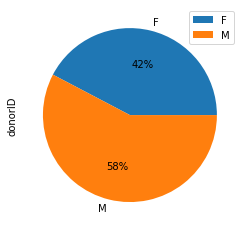

In [494]:
#create pie chart
donors.groupby(['gender']).sum().plot(kind='pie', y='donorID', autopct='%1.0f%%')

<AxesSubplot:ylabel='donorID'>

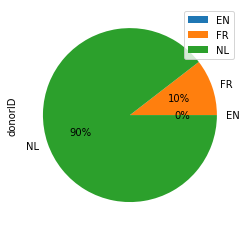

In [495]:
#create pie chart
donors.groupby(['language']).sum().plot(kind='pie', y='donorID', autopct='%1.0f%%')

In [496]:
#Replacing the missing zipcode with 3080 as it's the most frequent value where:
#language=EN, region=Flanders & province=Flemish Brabant
donors['zipcode'].fillna(3080,inplace=True)
# use missing to fill missing values
donors['gender'].fillna('Missing',inplace=True)


#Along with the zipcode 3080, replacing respective Province and  Region too
donors['province'] = donors['province'].str.replace('Missing', 'Flemish Brabant')
donors['province'] = np.where(donors['province'] == 'ANTWERP','Antwerp',donors['province'])
donors['region'] = donors['region'].str.replace('Missing', 'Flanders')

In [497]:
# we see that there are null values, we shall adopt one hot encoding for this and assign a new column for missing values
donors.gender.unique()

array(['F', 'M', 'Missing'], dtype=object)

In [498]:
#Change the datatype of birthdate
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

###Converting the zipcode to int
donors['zipcode'] = donors['zipcode'].astype(int)

In [499]:
# get age and age_group
donors["age"] = donors["dateOfBirth"].apply(lambda x : (2018 - x.year))

In [500]:
#ONE HOT ENCODING GENDER
genders = pd.get_dummies(donors['gender'])
genders.columns = ['Gender_M', 'Gender_F', 'Gender_Missing']
donors = donors.join(genders)
donors.drop('gender', axis=1, inplace=True)
donors.head()


#ONE HOT ENCODING LANGUAGE 
languages = pd.get_dummies(donors['language'])
languages.columns = ['EN', 'FR', 'NL']
donors = donors.join(languages)
donors.drop('language', axis=1, inplace=True)
donors.head()


# ONE HOT ENCODING PROVINCE
provinces = pd.get_dummies(donors['province'])
provinces.columns = ['Flemish Brabant', 'Antwerp', 'Brussels', 'Walloon Brabant',
       'West Flanders', 'East Flanders', 'Liege', 'Luxembourg', 'Namur',
       'Hainaut', 'Limburg'] #removed Missing as its replaced with Flemish Brabant
donors = donors.join(provinces)
donors.drop('province', axis=1, inplace=True)
donors.head()

,donorID,zipcode,region,dateOfBirth,age,Gender_M,Gender_F,Gender_Missing,EN,FR,...,Antwerp,Brussels,Walloon Brabant,West Flanders,East Flanders,Liege,Luxembourg,Namur,Hainaut,Limburg
0,100001,1861,Flanders,1967-12-24,51,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,100002,2260,Flanders,1952-01-14,66,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100003,1780,Flanders,1986-12-23,32,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,100004,1020,Brussels,1952-03-29,66,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,100005,1020,Brussels,1986-06-25,32,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


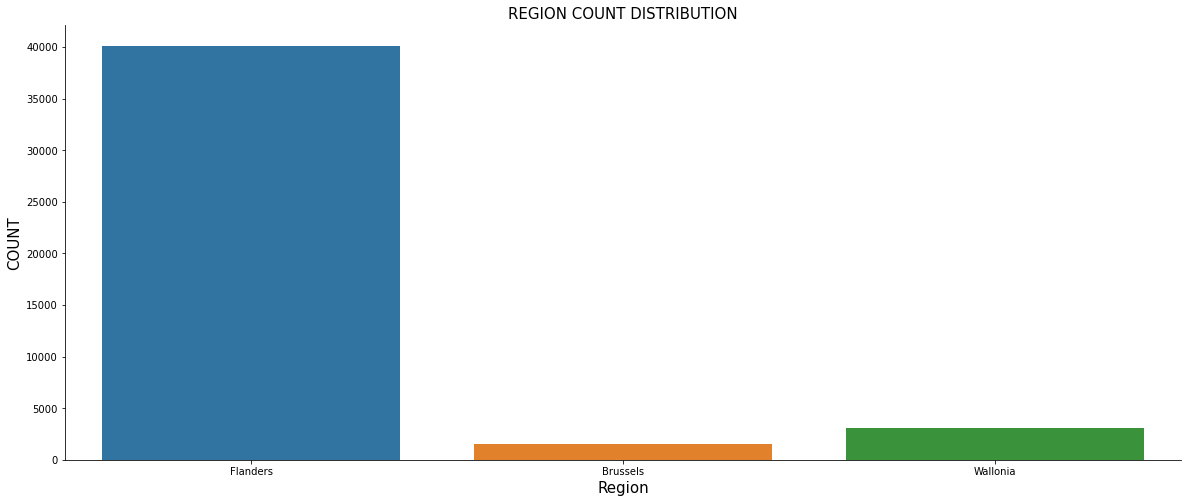

In [501]:
#visualization
cols_num = ['donorID','zipcode','region','age','Gender_M','Gender_F','Gender_Missing','EN', 'FR', 'NL',
            'Antwerp','Brussels','Walloon Brabant','West Flanders','East Flanders','Liege','Luxembourg','Namur','Hainaut','Limburg']
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'region', data =  donors[cols_num])
ax.set_xlabel('Region', fontsize=15)
ax.set_ylabel('COUNT', fontsize=15)
ax.set_title('REGION COUNT DISTRIBUTION', fontsize=15)
sns.despine()

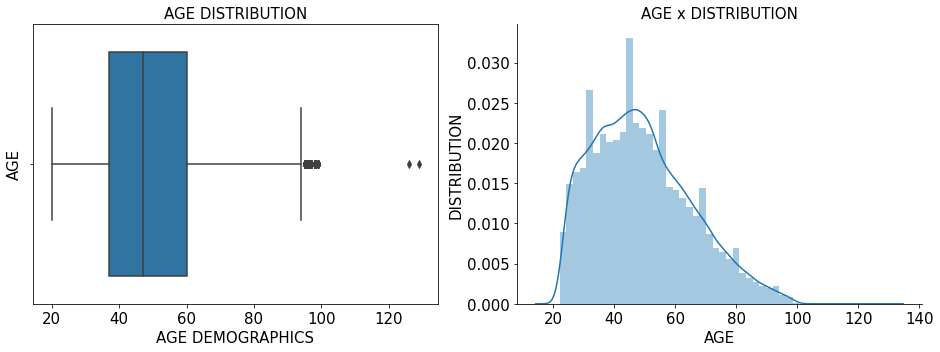

In [502]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'age', data = donors[cols_num], orient = 'v', ax = ax1)
ax1.set_xlabel('AGE DEMOGRAPHICS', fontsize=15)
ax1.set_ylabel('AGE', fontsize=15)
ax1.set_title('AGE DISTRIBUTION', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(donors[cols_num]['age'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('AGE', fontsize=15)
ax2.set_ylabel('DISTRIBUTION', fontsize=15)
ax2.set_title('AGE x DISTRIBUTION', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

In [503]:
#Checking the mean age of the donors to fix outliers
donors['age'].mean()

49.305533800264044

In [504]:
#dropping the dateOfBirth column
donors.drop('dateOfBirth', axis=1, inplace=True)

#Checking the donors whose age is greater than 100
donors[(donors['age'] >= 100)]

,donorID,zipcode,region,age,Gender_M,Gender_F,Gender_Missing,EN,FR,NL,...,Antwerp,Brussels,Walloon Brabant,West Flanders,East Flanders,Liege,Luxembourg,Namur,Hainaut,Limburg
27008,127009,9000,Flanders,129,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
27453,127454,8820,Flanders,126,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [505]:
#checking the data
donors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44689 entries, 0 to 44690
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   donorID          44689 non-null  int64 
 1   zipcode          44689 non-null  int32 
 2   region           44689 non-null  object
 3   age              44689 non-null  int64 
 4   Gender_M         44689 non-null  uint8 
 5   Gender_F         44689 non-null  uint8 
 6   Gender_Missing   44689 non-null  uint8 
 7   EN               44689 non-null  uint8 
 8   FR               44689 non-null  uint8 
 9   NL               44689 non-null  uint8 
 10  Flemish Brabant  44689 non-null  uint8 
 11  Antwerp          44689 non-null  uint8 
 12  Brussels         44689 non-null  uint8 
 13  Walloon Brabant  44689 non-null  uint8 
 14  West Flanders    44689 non-null  uint8 
 15  East Flanders    44689 non-null  uint8 
 16  Liege            44689 non-null  uint8 
 17  Luxembourg       44689 non-null

In [506]:
#Replacing the donor age 129 & 126 with correct values
donors['age']=donors['age'].replace([129],29)
donors['age']=donors['age'].replace([126],26)

In [507]:
#checking the length of data
population = len(donors)
population

44689

## GIFTS

In [508]:
# Load gifts dataset
gifts = pd.read_csv('../dsc_data/gifts.csv', sep=',')

In [509]:
# info of the dataset
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  216594 non-null  int64  
 1   donorID     216594 non-null  int64  
 2   campaignID  200957 non-null  float64
 3   amount      216594 non-null  object 
 4   date        216594 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 8.3+ MB


In [510]:
#checking the shape
gifts.shape

(216594, 5)

In [511]:
#Deleting unnamed column 
gifts.drop(columns =['Unnamed: 0'],inplace = True)

In [512]:
#replace comma with dot from amount before converting it to float
gifts['amount']= gifts['amount'].str.replace(",",".").astype(float)

In [513]:
# fill missing values in campaignID with 0
gifts['campaignID'] = gifts['campaignID'].fillna(0)
gifts['campaignID'] = gifts['campaignID'].astype(int)

In [514]:
# changing date datatype
gifts['date'] = pd.to_datetime(gifts['date'])

# extract year month and day from date
gifts['gift_year'] = pd.DatetimeIndex(gifts['date']).year
gifts['gift_month'] = pd.DatetimeIndex(gifts['date']).month
gifts['gift_day'] = pd.DatetimeIndex(gifts['date']).day

end_target = datetime.datetime(year = 2018, month = 9, day = 4)

In [515]:
#checking the average amount donated in year 2019
gifts[gifts["gift_year"]==2019]['amount'].mean()

33.390663289429206

In [516]:
#selecting the donors with campaignID = 6169
gifts_campaign69 = gifts[gifts["campaignID"] == 6169]
gifts_campaign69.head()

,donorID,campaignID,amount,date,gift_year,gift_month,gift_day
132,100023,6169,15.0,2018-09-15,2018,9,15
705,100126,6169,123.0,2018-09-11,2018,9,11
1151,100253,6169,120.0,2018-09-18,2018,9,18
1362,100279,6169,75.0,2018-09-13,2018,9,13
1804,100320,6169,135.0,2018-09-09,2018,9,9


In [517]:
#target variable based on the campaign Id and the Amount donated
gifts_target = gifts_campaign69.groupby(["donorID"])["amount"].sum().reset_index()
gifts_target.columns = ["donorID", "amount"]
len(gifts_target)

1191

In [518]:
#select historical data before the campaign 6169 started on 04-Sep-2018
gifts_campaign = gifts[(gifts["date"] < end_target)]
len(gifts_campaign)

208334

In [519]:
#checking the dataset
gifts_campaign.head()

,donorID,campaignID,amount,date,gift_year,gift_month,gift_day
0,100001,0,12.39,2004-03-23,2004,3,23
1,100001,1577,12.39,2007-10-11,2007,10,11
2,100001,1634,6.69,2007-12-28,2007,12,28
3,100001,1778,24.79,2008-06-14,2008,6,14
4,100001,1808,7.44,2008-07-09,2008,7,9


In [520]:
#creating aggregate function for the train data
basetable_target = gifts_campaign.groupby(["donorID"])["amount"].agg(['sum', 'count']).reset_index()
basetable_target.head()

,donorID,sum,count
0,100001,178.49,12
1,100002,20.00,1
2,100003,18.00,5
3,100004,716.22,26
4,100005,14.96,4


In [521]:
#Setting the timeline for amount donated in the last one year
end_target = datetime.datetime(year = 2018,  month = 9, day = 4)
start_target =  datetime.datetime(year= 2017, month = 9, day = 4)

#Calculating the amount donated in the last one year
gifts_1y = gifts_campaign[(gifts_campaign['date'] <= end_target) & (gifts_campaign["date"] >= start_target)] 

# Group and sum donations by donor
gifts_1y_camp = gifts_1y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_1y_camp.columns = ["donorID", "1y_camp_count", "1y_camp_sum"]

In [522]:
#Merging gifts_1y to basetable_target
basetable_target = basetable_target.merge(gifts_1y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44686 non-null  int64  
 1   sum            44686 non-null  float64
 2   count          44686 non-null  int64  
 3   1y_camp_count  2524 non-null   float64
 4   1y_camp_sum    2524 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 2.0 MB


In [523]:
#Setting the timeline for amount donated in the last two years
end_target = datetime.datetime(year = 2017,  month = 9, day = 4)
start_target =  datetime.datetime(year= 2015, month = 9, day = 4)

#Calculating the amount donated in the last two years
gifts_2y = gifts_campaign[(gifts_campaign['date'] <= end_target) & (gifts_campaign["date"] >= start_target)] 

# Group and sum donations by donor
gifts_2y_camp = gifts_2y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_2y_camp.columns = ["donorID", "2y_camp_count", "2y_camp_sum"]

In [524]:
#Merging gifts_2y to basetable_target
basetable_target = basetable_target.merge(gifts_2y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44686 non-null  int64  
 1   sum            44686 non-null  float64
 2   count          44686 non-null  int64  
 3   1y_camp_count  2524 non-null   float64
 4   1y_camp_sum    2524 non-null   float64
 5   2y_camp_count  9163 non-null   float64
 6   2y_camp_sum    9163 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 2.7 MB


In [525]:
#Setting the timeline for amount donated in the last four years
end_target =  datetime.datetime(year= 2015, month = 9, day = 4)
start_target =  datetime.datetime(year= 2011, month = 9, day = 4)

#Calculating the amount donated in the last two years
gifts_4y = gifts_campaign[(gifts_campaign['date'] <= end_target) & (gifts_campaign["date"] >= start_target)]

# Group and sum donations by donor
gifts_4y_camp = gifts_4y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_4y_camp.columns = ["donorID", "4y_camp_count", "4y_camp_sum"]

In [526]:
#Merging gifts_4y with basetable_target
basetable_target = basetable_target.merge(gifts_4y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44686 non-null  int64  
 1   sum            44686 non-null  float64
 2   count          44686 non-null  int64  
 3   1y_camp_count  2524 non-null   float64
 4   1y_camp_sum    2524 non-null   float64
 5   2y_camp_count  9163 non-null   float64
 6   2y_camp_sum    9163 non-null   float64
 7   4y_camp_count  23280 non-null  float64
 8   4y_camp_sum    23280 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 3.4 MB


In [527]:
#Setting the timeline for amount donated in the last four years
end_target =  datetime.datetime(year= 2011, month = 9, day = 4)
start_target =  datetime.datetime(year= 2005, month = 9, day = 4)

#Calculating the amount donated in the last two years
gifts_6y = gifts_campaign[(gifts_campaign['date'] <= end_target) & (gifts_campaign["date"] >= start_target)]

# Group and sum donations by donor
gifts_6y_camp = gifts_6y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_6y_camp.columns = ["donorID", "6y_camp_count", "6y_camp_sum"]

In [528]:
#Merging gifts_6y to basetable_target
basetable_target = basetable_target.merge(gifts_6y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44686 non-null  int64  
 1   sum            44686 non-null  float64
 2   count          44686 non-null  int64  
 3   1y_camp_count  2524 non-null   float64
 4   1y_camp_sum    2524 non-null   float64
 5   2y_camp_count  9163 non-null   float64
 6   2y_camp_sum    9163 non-null   float64
 7   4y_camp_count  23280 non-null  float64
 8   4y_camp_sum    23280 non-null  float64
 9   6y_camp_count  26401 non-null  float64
 10  6y_camp_sum    26401 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.1 MB


In [529]:
#calculating the gift first and last year for donors
gift_first_last_year = gifts.groupby('donorID').agg(gift_first_year = ('gift_year',min), gift_last_year = ('gift_year',max)).reset_index()

In [530]:
#Calculating the last and first period of donations by donors
gift_first_last_year['gift_first_year'] = 2018 - gift_first_last_year['gift_first_year']
gift_first_last_year['gift_last_year'] = gift_first_last_year['gift_last_year']
basetable_target =  basetable_target.merge(gift_first_last_year, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   donorID          44686 non-null  int64  
 1   sum              44686 non-null  float64
 2   count            44686 non-null  int64  
 3   1y_camp_count    2524 non-null   float64
 4   1y_camp_sum      2524 non-null   float64
 5   2y_camp_count    9163 non-null   float64
 6   2y_camp_sum      9163 non-null   float64
 7   4y_camp_count    23280 non-null  float64
 8   4y_camp_sum      23280 non-null  float64
 9   6y_camp_count    26401 non-null  float64
 10  6y_camp_sum      26401 non-null  float64
 11  gift_first_year  44686 non-null  int64  
 12  gift_last_year   44686 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 4.8 MB


In [531]:
 gifts_total = gifts_campaign.groupby('donorID') \
                        .agg(total_camp_count = ('campaignID','count'), total_camp_amt = ('amount','sum'), \
                            total_camp_min_amt = ('amount','min'), total_camp_max_amt = ('amount','max')).reset_index()
gifts_total['total_amt_greater_30'] = np.where(gifts_total['total_camp_max_amt'] > 35, 1,0)
gifts_total['total_amt_greater_60'] = np.where(gifts_total['total_camp_max_amt'] > 60, 1,0)
gifts_total['total_amt_greater_100'] = np.where(gifts_total['total_camp_max_amt'] > 100, 1,0)
basetable_target =  basetable_target.merge(gifts_total, left_on = 'donorID', right_on = 'donorID', how='left')

basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                44686 non-null  int64  
 1   sum                    44686 non-null  float64
 2   count                  44686 non-null  int64  
 3   1y_camp_count          2524 non-null   float64
 4   1y_camp_sum            2524 non-null   float64
 5   2y_camp_count          9163 non-null   float64
 6   2y_camp_sum            9163 non-null   float64
 7   4y_camp_count          23280 non-null  float64
 8   4y_camp_sum            23280 non-null  float64
 9   6y_camp_count          26401 non-null  float64
 10  6y_camp_sum            26401 non-null  float64
 11  gift_first_year        44686 non-null  int64  
 12  gift_last_year         44686 non-null  int64  
 13  total_camp_count       44686 non-null  int64  
 14  total_camp_amt         44686 non-null  float64
 15  to

In [532]:
basetable_target.tail()

,donorID,sum,count,1y_camp_count,1y_camp_sum,2y_camp_count,2y_camp_sum,4y_camp_count,4y_camp_sum,6y_camp_count,6y_camp_sum,gift_first_year,gift_last_year,total_camp_count,total_camp_amt,total_camp_min_amt,total_camp_max_amt,total_amt_greater_30,total_amt_greater_60,total_amt_greater_100
44681,144687,10.00,1,NaN,NaN,1.0,10.0,NaN,NaN,NaN,NaN,3,2015,1,10.00,10.00,10.0,0,0,0
44682,144688,48.56,7,NaN,NaN,1.0,15.0,NaN,NaN,6.0,33.56,10,2017,7,48.56,2.48,15.0,0,0,0
44683,144689,124.79,2,1.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,13,2019,2,124.79,24.79,100.0,1,1,0
44684,144690,40.00,1,NaN,NaN,NaN,NaN,1.0,40.0,NaN,NaN,4,2014,1,40.00,40.00,40.0,1,0,0
44685,144691,39.00,1,NaN,NaN,1.0,39.0,NaN,NaN,NaN,NaN,3,2015,1,39.00,39.00,39.0,1,0,0


In [533]:
#Merging donors with basetable_target
basetable_target = basetable_target.merge(donors, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                44686 non-null  int64  
 1   sum                    44686 non-null  float64
 2   count                  44686 non-null  int64  
 3   1y_camp_count          2524 non-null   float64
 4   1y_camp_sum            2524 non-null   float64
 5   2y_camp_count          9163 non-null   float64
 6   2y_camp_sum            9163 non-null   float64
 7   4y_camp_count          23280 non-null  float64
 8   4y_camp_sum            23280 non-null  float64
 9   6y_camp_count          26401 non-null  float64
 10  6y_camp_sum            26401 non-null  float64
 11  gift_first_year        44686 non-null  int64  
 12  gift_last_year         44686 non-null  int64  
 13  total_camp_count       44686 non-null  int64  
 14  total_camp_amt         44686 non-null  float64
 15  to

CAMPAIGN 6169 DATA ANALYSIS

In [534]:
#reading in the data and merging it with basetable
selected_donors  = pd.read_csv('../dsc_data/selection campaign 6169.csv', sep=',')
basetable_target = pd.merge(selected_donors, basetable_target, on = 'donorID', how='left')

In [535]:
#info of dataset
basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                34888 non-null  int64  
 1   sum                    34869 non-null  float64
 2   count                  34869 non-null  float64
 3   1y_camp_count          276 non-null    float64
 4   1y_camp_sum            276 non-null    float64
 5   2y_camp_count          2212 non-null   float64
 6   2y_camp_sum            2212 non-null   float64
 7   4y_camp_count          17791 non-null  float64
 8   4y_camp_sum            17791 non-null  float64
 9   6y_camp_count          22575 non-null  float64
 10  6y_camp_sum            22575 non-null  float64
 11  gift_first_year        34869 non-null  float64
 12  gift_last_year         34869 non-null  float64
 13  total_camp_count       34869 non-null  float64
 14  total_camp_amt         34869 non-null  float64
 15  to

In [536]:
#replacing missing values by 0
basetable_target["sum"] = basetable_target["sum"].replace(np.nan, 0)
basetable_target["count"] = basetable_target["count"].replace(np.nan, 0)
basetable_target["1y_camp_count"] = basetable_target["1y_camp_count"].replace(np.nan, 0)
basetable_target["1y_camp_sum"] = basetable_target["1y_camp_sum"].replace(np.nan, 0)
basetable_target["2y_camp_count"] = basetable_target["2y_camp_count"].replace(np.nan, 0)
basetable_target["2y_camp_sum"] = basetable_target["2y_camp_sum"].replace(np.nan, 0)
basetable_target["4y_camp_count"] = basetable_target["4y_camp_count"].replace(np.nan, 0)
basetable_target["4y_camp_sum"] = basetable_target["4y_camp_sum"].replace(np.nan, 0)
basetable_target["6y_camp_count"] = basetable_target["6y_camp_count"].replace(np.nan, 0)
basetable_target["6y_camp_sum"] = basetable_target["6y_camp_sum"].replace(np.nan, 0)
basetable_target["gift_first_year"] = basetable_target["gift_first_year"].replace(np.nan, 0)
basetable_target["gift_last_year"] = basetable_target["gift_last_year"].replace(np.nan, 0)
basetable_target["total_camp_count"] = basetable_target["total_camp_count"].replace(np.nan, 0)
basetable_target["total_camp_amt"] = basetable_target["total_camp_amt"].replace(np.nan, 0)
basetable_target["total_camp_min_amt"] = basetable_target["total_camp_min_amt"].replace(np.nan, 0)
basetable_target["total_camp_max_amt"] = basetable_target["total_camp_max_amt"].replace(np.nan, 0)
basetable_target["total_amt_greater_30"] = basetable_target["total_amt_greater_30"].replace(np.nan, 0)
basetable_target["total_amt_greater_60"] = basetable_target["total_amt_greater_60"].replace(np.nan, 0)
basetable_target["total_amt_greater_100"] = basetable_target["total_amt_greater_100"].replace(np.nan, 0)

In [537]:
#filling na values with missing
basetable_target['region'] = basetable_target['region'].fillna('missing')

In [538]:
#checking for unique variables
basetable_target['region'].unique()

array(['Flanders', 'Brussels', 'Wallonia', 'missing'], dtype=object)

In [539]:
#deriviing has_contributed variable and add has_contributed to the basetable
has_contributed = list(gifts_target["donorID"][gifts_target["amount"] > 30])

basetable_target["has_contributed"] = pd.Series([1 if donorID in has_contributed else 0 for donorID in basetable_target["donorID"]])
basetable_target.head(4)

,donorID,sum,count,1y_camp_count,1y_camp_sum,2y_camp_count,2y_camp_sum,4y_camp_count,4y_camp_sum,6y_camp_count,...,Brussels,Walloon Brabant,West Flanders,East Flanders,Liege,Luxembourg,Namur,Hainaut,Limburg,has_contributed
0,100001,178.49,12.0,0.0,0.0,0.0,0.0,1.0,10.0,10.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100002,20.00,1.0,0.0,0.0,0.0,0.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,716.22,26.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100008,124.37,3.0,0.0,0.0,0.0,0.0,1.0,50.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [540]:
#writing out the data into a csv
basetable_target.to_csv('../dsc_data/basetable_targetdata.csv')

CAMPAIGN 7244 ANALYSIS

In [541]:
#Reading in the file
select_campaign = pd.read_csv('../dsc_data/selection campaign 7244.csv')
select_campaign.head()
len(select_campaign)

25645

In [542]:
#calculating number of donors as at the end date
end_date = datetime.datetime(year=2019, month=6, day=18)

gifts_camp = gifts[(gifts["date"] < end_date)]

len(gifts_camp)

214231

In [543]:
#selecting donors with campaignID 7244
gifts_campaign44 = gifts[gifts["campaignID"] == 7244]
len(gifts_campaign44)

361

In [544]:
#creating aggregate function for the train data
basetable_trait = gifts_campaign.groupby(["donorID"])["amount"].agg(['sum', 'count']).reset_index()
basetable_trait.head()

,donorID,sum,count
0,100001,178.49,12
1,100002,20.00,1
2,100003,18.00,5
3,100004,716.22,26
4,100005,14.96,4


In [545]:
#grouping by the donorId
gifts_test = gifts_campaign44.groupby(["donorID"])["amount"].sum().reset_index()
gifts_test.columns = ["donorID", "amount"]
gifts_test.head()

,donorID,amount
0,100724,40.0
1,100896,10.0
2,100964,100.0
3,101066,60.0
4,101069,80.0


In [546]:
#Setting the timeline for amount donated in the last one year
end_date = datetime.datetime(year = 2019,  month = 6, day = 18)
start_date =  datetime.datetime(year= 2018, month = 6, day = 18)

#Calculating the amount donated in the last one year
gifts_1y = gifts_camp[(gifts_camp['date'] <= end_date) & (gifts_camp["date"] >= start_date)] 

# Group and sum donations by donor
gifts_1y_camp = gifts_1y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_1y_camp.columns = ["donorID", "1y_camp_count", "1y_camp_sum"]

In [547]:
#Merging gifts_1y to basetable_trait
basetable_trait = basetable_trait.merge(gifts_1y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44686 non-null  int64  
 1   sum            44686 non-null  float64
 2   count          44686 non-null  int64  
 3   1y_camp_count  4318 non-null   float64
 4   1y_camp_sum    4318 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 2.0 MB


In [548]:
#Setting the timeline for amount donated in the last two years
end_date = datetime.datetime(year = 2018,  month = 6, day = 18)
start_date =  datetime.datetime(year= 2016, month = 6, day = 18)

#Calculating the amount donated in the last two years
gifts_2y = gifts_camp[(gifts_camp['date'] <= end_date) & (gifts_camp["date"] >= start_date)] 

# Group and sum donations by donor
gifts_2y_camp = gifts_2y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_2y_camp.columns = ["donorID", "2y_camp_count", "2y_camp_sum"]

In [549]:
#Merging gifts_2y to basetable_trait
basetable_trait = basetable_trait.merge(gifts_2y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44686 non-null  int64  
 1   sum            44686 non-null  float64
 2   count          44686 non-null  int64  
 3   1y_camp_count  4318 non-null   float64
 4   1y_camp_sum    4318 non-null   float64
 5   2y_camp_count  7691 non-null   float64
 6   2y_camp_sum    7691 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 2.7 MB


In [550]:
#Setting the timeline for amount donated in the last four years
end_date = datetime.datetime(year = 2016,  month = 6, day = 18)
start_date =  datetime.datetime(year= 2012, month = 6, day = 18)

#Calculating the amount donated in the last four years
gifts_4y = gifts_camp[(gifts_camp['date'] <= end_date) & (gifts_camp["date"] >= start_date)] 

# Group and sum donations by donor
gifts_4y_camp = gifts_4y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_4y_camp.columns = ["donorID", "4y_camp_count", "4y_camp_sum"]

In [551]:
#Merging gifts_4y to basetable_trait
basetable_trait = basetable_trait.merge(gifts_4y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44686 non-null  int64  
 1   sum            44686 non-null  float64
 2   count          44686 non-null  int64  
 3   1y_camp_count  4318 non-null   float64
 4   1y_camp_sum    4318 non-null   float64
 5   2y_camp_count  7691 non-null   float64
 6   2y_camp_sum    7691 non-null   float64
 7   4y_camp_count  20374 non-null  float64
 8   4y_camp_sum    20374 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 3.4 MB


In [552]:
#Setting the timeline for amount donated in the last six years
end_date = datetime.datetime(year = 2012,  month = 6, day = 18)
start_date =  datetime.datetime(year= 2006, month = 6, day = 18)

#Calculating the amount donated in the last six years
gifts_6y = gifts_camp[(gifts_camp['date'] <= end_date) & (gifts_camp["date"] >= start_date)] 

# Group and sum donations by donor
gifts_6y_camp = gifts_6y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_6y_camp.columns = ["donorID", "6y_camp_count", "6y_camp_sum"]

In [553]:
#Merging gifts_6y to basetable_trait
basetable_trait = basetable_trait.merge(gifts_6y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44686 non-null  int64  
 1   sum            44686 non-null  float64
 2   count          44686 non-null  int64  
 3   1y_camp_count  4318 non-null   float64
 4   1y_camp_sum    4318 non-null   float64
 5   2y_camp_count  7691 non-null   float64
 6   2y_camp_sum    7691 non-null   float64
 7   4y_camp_count  20374 non-null  float64
 8   4y_camp_sum    20374 non-null  float64
 9   6y_camp_count  29224 non-null  float64
 10  6y_camp_sum    29224 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.1 MB


In [554]:
#calculating the gift first and last year for donors
gift_first_last_year = gifts.groupby('donorID').agg(gift_first_year = ('gift_year',min), gift_last_year = ('gift_year',max)).reset_index()

In [555]:
#Calculating the last and first period of donations by donors
gift_first_last_year['gift_first_year'] = 2019 - gift_first_last_year['gift_first_year']
gift_first_last_year['gift_last_year'] = gift_first_last_year['gift_last_year']
basetable_trait =  basetable_trait.merge(gift_first_last_year, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   donorID          44686 non-null  int64  
 1   sum              44686 non-null  float64
 2   count            44686 non-null  int64  
 3   1y_camp_count    4318 non-null   float64
 4   1y_camp_sum      4318 non-null   float64
 5   2y_camp_count    7691 non-null   float64
 6   2y_camp_sum      7691 non-null   float64
 7   4y_camp_count    20374 non-null  float64
 8   4y_camp_sum      20374 non-null  float64
 9   6y_camp_count    29224 non-null  float64
 10  6y_camp_sum      29224 non-null  float64
 11  gift_first_year  44686 non-null  int64  
 12  gift_last_year   44686 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 4.8 MB


In [556]:
#creating new variables
gifts_total = gifts_campaign.groupby('donorID') \
                        .agg(total_camp_count = ('campaignID','count'), total_camp_amt = ('amount','sum'), \
                            total_camp_min_amt = ('amount','min'), total_camp_max_amt = ('amount','max')).reset_index()
gifts_total['total_amt_greater_30'] = np.where(gifts_total['total_camp_max_amt'] > 35, 1,0)
gifts_total['total_amt_greater_60'] = np.where(gifts_total['total_camp_max_amt'] > 60, 1,0)
gifts_total['total_amt_greater_100'] = np.where(gifts_total['total_camp_max_amt'] > 100, 1,0)
basetable_trait =  basetable_trait.merge(gifts_total, left_on = 'donorID', right_on = 'donorID', how='left')

basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                44686 non-null  int64  
 1   sum                    44686 non-null  float64
 2   count                  44686 non-null  int64  
 3   1y_camp_count          4318 non-null   float64
 4   1y_camp_sum            4318 non-null   float64
 5   2y_camp_count          7691 non-null   float64
 6   2y_camp_sum            7691 non-null   float64
 7   4y_camp_count          20374 non-null  float64
 8   4y_camp_sum            20374 non-null  float64
 9   6y_camp_count          29224 non-null  float64
 10  6y_camp_sum            29224 non-null  float64
 11  gift_first_year        44686 non-null  int64  
 12  gift_last_year         44686 non-null  int64  
 13  total_camp_count       44686 non-null  int64  
 14  total_camp_amt         44686 non-null  float64
 15  to

In [557]:
#Merging donors with basetable_trait
basetable_trait = basetable_trait.merge(donors, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 0 to 44685
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                44686 non-null  int64  
 1   sum                    44686 non-null  float64
 2   count                  44686 non-null  int64  
 3   1y_camp_count          4318 non-null   float64
 4   1y_camp_sum            4318 non-null   float64
 5   2y_camp_count          7691 non-null   float64
 6   2y_camp_sum            7691 non-null   float64
 7   4y_camp_count          20374 non-null  float64
 8   4y_camp_sum            20374 non-null  float64
 9   6y_camp_count          29224 non-null  float64
 10  6y_camp_sum            29224 non-null  float64
 11  gift_first_year        44686 non-null  int64  
 12  gift_last_year         44686 non-null  int64  
 13  total_camp_count       44686 non-null  int64  
 14  total_camp_amt         44686 non-null  float64
 15  to

In [558]:
#Merging basetable_trait and select_campaign
basetable_trait = pd.merge(select_campaign, basetable_trait, on = "donorID", how = "left")
len(basetable_trait)
basetable_trait.head(2)

,donorID,sum,count,1y_camp_count,1y_camp_sum,2y_camp_count,2y_camp_sum,4y_camp_count,4y_camp_sum,6y_camp_count,...,Antwerp,Brussels,Walloon Brabant,West Flanders,East Flanders,Liege,Luxembourg,Namur,Hainaut,Limburg
0,100001,178.49,12.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,20.00,1.0,NaN,NaN,NaN,NaN,1.0,20.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [559]:
#checking the data
basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                25645 non-null  int64  
 1   sum                    25644 non-null  float64
 2   count                  25644 non-null  float64
 3   1y_camp_count          212 non-null    float64
 4   1y_camp_sum            212 non-null    float64
 5   2y_camp_count          1558 non-null   float64
 6   2y_camp_sum            1558 non-null   float64
 7   4y_camp_count          12683 non-null  float64
 8   4y_camp_sum            12683 non-null  float64
 9   6y_camp_count          17366 non-null  float64
 10  6y_camp_sum            17366 non-null  float64
 11  gift_first_year        25644 non-null  float64
 12  gift_last_year         25644 non-null  float64
 13  total_camp_count       25644 non-null  float64
 14  total_camp_amt         25644 non-null  float64
 15  to

In [560]:
#replacing missing values by 0
basetable_trait["sum"] = basetable_trait["sum"].replace(np.nan, 0)
basetable_trait["count"] = basetable_trait["count"].replace(np.nan, 0)
basetable_trait["1y_camp_count"] = basetable_trait["1y_camp_count"].replace(np.nan, 0)
basetable_trait["1y_camp_sum"] = basetable_trait["1y_camp_sum"].replace(np.nan, 0)
basetable_trait["2y_camp_count"] = basetable_trait["2y_camp_count"].replace(np.nan, 0)
basetable_trait["2y_camp_sum"] = basetable_trait["2y_camp_sum"].replace(np.nan, 0)
basetable_trait["4y_camp_count"] = basetable_trait["4y_camp_count"].replace(np.nan, 0)
basetable_trait["4y_camp_sum"] = basetable_trait["4y_camp_sum"].replace(np.nan, 0)
basetable_trait["6y_camp_count"] = basetable_trait["6y_camp_count"].replace(np.nan, 0)
basetable_trait["6y_camp_sum"] = basetable_trait["6y_camp_sum"].replace(np.nan, 0)
basetable_trait["gift_first_year"] = basetable_trait["gift_first_year"].replace(np.nan, 0)
basetable_trait["gift_last_year"] = basetable_trait["gift_last_year"].replace(np.nan, 0)
basetable_trait["total_camp_count"] = basetable_trait["total_camp_count"].replace(np.nan, 0)
basetable_trait["total_camp_amt"] = basetable_trait["total_camp_amt"].replace(np.nan, 0)
basetable_trait["total_camp_min_amt"] = basetable_trait["total_camp_min_amt"].replace(np.nan, 0)
basetable_trait["total_camp_max_amt"] = basetable_trait["total_camp_max_amt"].replace(np.nan, 0)
basetable_trait["total_amt_greater_30"] = basetable_trait["total_amt_greater_30"].replace(np.nan, 0)
basetable_trait["total_amt_greater_60"] = basetable_trait["total_amt_greater_60"].replace(np.nan, 0)
basetable_trait["total_amt_greater_100"] = basetable_trait["total_amt_greater_100"].replace(np.nan, 0)

In [561]:
#filling nas with  missing 
basetable_trait['region'] = basetable_trait['region'].fillna('missing')

In [562]:
#checking for unique values in column
basetable_trait['region'].unique()

array(['Flanders', 'Brussels', 'Wallonia', 'missing'], dtype=object)

In [563]:
#deriviing has_contributed variable and add has_contributed to the basetable
has_contributed = list(gifts_test["donorID"][gifts_test["amount"] > 30])

basetable_trait["has_contributed"] = pd.Series([1 if donorID in has_contributed else 0 for donorID in basetable_trait["donorID"]])
basetable_trait.head()

,donorID,sum,count,1y_camp_count,1y_camp_sum,2y_camp_count,2y_camp_sum,4y_camp_count,4y_camp_sum,6y_camp_count,...,Brussels,Walloon Brabant,West Flanders,East Flanders,Liege,Luxembourg,Namur,Hainaut,Limburg,has_contributed
0,100001,178.49,12.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100002,20.00,1.0,0.0,0.0,0.0,0.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100008,124.37,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100009,326.78,19.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,100010,40.00,1.0,0.0,0.0,0.0,0.0,1.0,40.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [564]:
#writing out the data into a csv file
basetable_trait.to_csv('../dsc_data/basetable_testdata.csv')

## Reading in our Processed Datasets

In [565]:
#Reading in our processed data
basetable_target = pd.read_csv('../dsc_data/basetable_targetdata.csv', sep=',')
basetable_trait = pd.read_csv('../dsc_data/basetable_testdata.csv', sep=',')

In [566]:
#checking the data
basetable_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             34888 non-null  int64  
 1   donorID                34888 non-null  int64  
 2   sum                    34888 non-null  float64
 3   count                  34888 non-null  float64
 4   1y_camp_count          34888 non-null  float64
 5   1y_camp_sum            34888 non-null  float64
 6   2y_camp_count          34888 non-null  float64
 7   2y_camp_sum            34888 non-null  float64
 8   4y_camp_count          34888 non-null  float64
 9   4y_camp_sum            34888 non-null  float64
 10  6y_camp_count          34888 non-null  float64
 11  6y_camp_sum            34888 non-null  float64
 12  gift_first_year        34888 non-null  float64
 13  gift_last_year         34888 non-null  float64
 14  total_camp_count       34888 non-null  float64
 15  to

In [567]:
#checking the data
basetable_trait.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             25645 non-null  int64  
 1   donorID                25645 non-null  int64  
 2   sum                    25645 non-null  float64
 3   count                  25645 non-null  float64
 4   1y_camp_count          25645 non-null  float64
 5   1y_camp_sum            25645 non-null  float64
 6   2y_camp_count          25645 non-null  float64
 7   2y_camp_sum            25645 non-null  float64
 8   4y_camp_count          25645 non-null  float64
 9   4y_camp_sum            25645 non-null  float64
 10  6y_camp_count          25645 non-null  float64
 11  6y_camp_sum            25645 non-null  float64
 12  gift_first_year        25645 non-null  float64
 13  gift_last_year         25645 non-null  float64
 14  total_camp_count       25645 non-null  float64
 15  to

## FEATURE SELECTION

In [568]:
#Library for modelling
import sys
from pandas                 import DataFrame
from pandas                 import read_csv
from numpy                  import array
from numpy                  import random
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from matplotlib             import pyplot
from scipy.stats            import pearsonr
from sklearn import preprocessing 
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [569]:
#Preprocessing before modelling
le = preprocessing.LabelEncoder()
basetable_target['region']  = le.fit_transform(basetable_target['region'])
basetable_target = basetable_target.fillna(0)
y = basetable_target['has_contributed']
basetable_target.drop('donorID', axis=1, inplace = True)
basetable_target.drop('Unnamed: 0', axis=1, inplace = True)
X = basetable_target.drop('has_contributed', axis=1)

In [570]:
#checking the data
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sum                    34888 non-null  float64
 1   count                  34888 non-null  float64
 2   1y_camp_count          34888 non-null  float64
 3   1y_camp_sum            34888 non-null  float64
 4   2y_camp_count          34888 non-null  float64
 5   2y_camp_sum            34888 non-null  float64
 6   4y_camp_count          34888 non-null  float64
 7   4y_camp_sum            34888 non-null  float64
 8   6y_camp_count          34888 non-null  float64
 9   6y_camp_sum            34888 non-null  float64
 10  gift_first_year        34888 non-null  float64
 11  gift_last_year         34888 non-null  float64
 12  total_camp_count       34888 non-null  float64
 13  total_camp_amt         34888 non-null  float64
 14  total_camp_min_amt     34888 non-null  float64
 15  to

In [571]:
#correlation 
X.corr().to_csv("cor.sv")

In [572]:
#data type of value
type(y)

pandas.core.series.Series

In [573]:
# Instanciate the models we want to try and create a models dictionary
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs")
randomForest = RandomForestClassifier(n_estimators = 25, n_jobs=-1)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

models = {"tree"         :tree,
         "logistic"     :logistic,
          "randomForest" :randomForest,
         "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
#           "neighbors"    :neighbors
         }

In [574]:
#splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [575]:
#printing out the test data
X_test

,sum,count,1y_camp_count,1y_camp_sum,2y_camp_count,2y_camp_sum,4y_camp_count,4y_camp_sum,6y_camp_count,6y_camp_sum,...,Antwerp,Brussels,Walloon Brabant,West Flanders,East Flanders,Liege,Luxembourg,Namur,Hainaut,Limburg
5337,239.57,10.0,0.0,0.0,0.0,0.0,3.0,110.0,7.0,129.57,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9809,80.00,4.0,0.0,0.0,0.0,0.0,4.0,80.0,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24075,50.00,1.0,0.0,0.0,0.0,0.0,1.0,50.0,0.0,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19057,25.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24991,40.00,4.0,0.0,0.0,0.0,0.0,2.0,15.0,2.0,25.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31948,39.00,1.0,0.0,0.0,0.0,0.0,1.0,39.0,0.0,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9418,280.00,5.0,0.0,0.0,0.0,0.0,3.0,180.0,2.0,100.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18885,97.50,7.0,0.0,0.0,0.0,0.0,2.0,22.5,5.0,75.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5290,8.68,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.48,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [576]:
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")
    
performances_train = {}
performances_test = {}

for model in models:
    predictions   = models[model].predict(X_train)
    probabilities = DataFrame(models[model].predict_proba(X_train))[1]
    accuracy      = accuracy_score(y_train,predictions)
    auc           = roc_auc_score(array(y_train),array(probabilities))

    performances_train[model] = {"Accuracy":accuracy,"AUC":auc}

for model in models:
    predictions   = models[model].predict(X_test)
    probabilities = DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    auc           = roc_auc_score(array(y_test),array(probabilities))

    performances_test[model] = {"Accuracy":accuracy,"AUC":auc}

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully


In [577]:
#Printing performance accuracy
DataFrame(performances_train)

,tree,logistic,randomForest,boostedTree,svm,neuralNet
Accuracy,0.999829,0.978480,0.999658,0.992813,0.978566,0.978566
AUC,0.999999,0.684899,0.999998,0.997683,0.508700,0.526565


In [578]:
#printing out performance accuracy
DataFrame(performances_test)

,tree,logistic,randomForest,boostedTree,svm,neuralNet
Accuracy,0.988188,0.979069,0.989578,0.991228,0.979243,0.979243
AUC,0.844469,0.667120,0.989525,0.996907,0.532574,0.532087


In [579]:
#preprocessing step before feauture selection
le = preprocessing.LabelEncoder()
basetable_trait['region']  = le.fit_transform(basetable_trait['region'])
basetable_trait = basetable_trait.fillna(0)
y_7244 = basetable_trait['has_contributed']
basetable_trait.drop('donorID', axis=1, inplace = True)
basetable_trait.drop('Unnamed: 0', axis=1, inplace = True)
X_7244 = basetable_trait.drop('has_contributed', axis=1)

In [580]:
#choosing model
y_pred_7244 = models['logistic'].predict(X_7244)

In [581]:
y_pred_7244

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [582]:
#printing roc
roc_auc_score(y_7244,models['logistic'].predict_proba(X_7244)[:, 1])

0.5408823208251671

In [583]:
#confusion matrix
confusion_matrix(y_7244, y_pred_7244)

array([[25433,     1],
       [  211,     0]], dtype=int64)

In [584]:
#Feature selection using Pearson 
selectedFeatures_pearson = []
target = "has_contributed"

for column in X.columns:
    if column not in ("donorID","has_contributed"):
        (pearson,pvalue) = pearsonr(X[column],y)
        print(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.001 else 0}")
        if pvalue < 0.001:
            selectedFeatures_pearson.append(column)

sum - p-vlue = 0.8873006320819409 - selected : 0
count - p-vlue = 0.3197696396771802 - selected : 0
1y_camp_count - p-vlue = 0.9828024173208608 - selected : 0
1y_camp_sum - p-vlue = 0.3327974832983973 - selected : 0
2y_camp_count - p-vlue = 0.46463961184706914 - selected : 0
2y_camp_sum - p-vlue = 0.0033251477229374925 - selected : 0
4y_camp_count - p-vlue = 0.011350960212660846 - selected : 0
4y_camp_sum - p-vlue = 1.462610041587624e-14 - selected : 1
6y_camp_count - p-vlue = 0.810341873251736 - selected : 0
6y_camp_sum - p-vlue = 0.8616765684038361 - selected : 0
gift_first_year - p-vlue = 0.4050753720244711 - selected : 0
gift_last_year - p-vlue = 5.457136260079574e-07 - selected : 1
total_camp_count - p-vlue = 0.3197696396771802 - selected : 0
total_camp_amt - p-vlue = 0.8873006320819409 - selected : 0
total_camp_min_amt - p-vlue = 0.8956617335072161 - selected : 0
total_camp_max_amt - p-vlue = 0.8479728345544097 - selected : 0
total_amt_greater_30 - p-vlue = 6.181872503945524e-141

In [585]:
#printing out selected features
selectedFeatures_pearson

['4y_camp_sum',
 'gift_last_year',
 'total_amt_greater_30',
 'total_amt_greater_60',
 'age',
 'Gender_M',
 'Gender_F']

In [586]:
#splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X[selectedFeatures_pearson], y, test_size=0.33, random_state=42)

In [587]:
# Instanciate the models we want to try and create a models dictionary
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs")
randomForest = RandomForestClassifier(n_estimators = 25, n_jobs=-1)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

models = {"tree"         :tree,
         "logistic"     :logistic,
          "randomForest" :randomForest,
         "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
#           "neighbors"    :neighbors
         }

In [588]:
#running models in loop
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")
    
performances_train = {}
performances_test = {}

for model in models:
    predictions   = models[model].predict(X_train)
    probabilities = DataFrame(models[model].predict_proba(X_train))[1]
    accuracy      = accuracy_score(y_train,predictions)
    auc           = roc_auc_score(array(y_train),array(probabilities))

    performances_train[model] = {"Accuracy":accuracy,"AUC":auc}

for model in models:
    predictions   = models[model].predict(X_test)
    probabilities = DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    auc           = roc_auc_score(array(y_test),array(probabilities))

    performances_test[model] = {"Accuracy":accuracy,"AUC":auc}

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully


In [589]:
#printing performance accuracy
DataFrame(performances_train)

,tree,logistic,randomForest,boostedTree,svm,neuralNet
Accuracy,0.996920,0.978566,0.996535,0.986352,0.978566,0.978566
AUC,0.999714,0.820735,0.999428,0.992769,0.772980,0.809100


In [590]:
#printing performance accuracy
DataFrame(performances_test)

,tree,logistic,randomForest,boostedTree,svm,neuralNet
Accuracy,0.979503,0.979243,0.981848,0.98567,0.979243,0.979243
AUC,0.775836,0.828251,0.956333,0.99178,0.783808,0.804618


In [591]:
y_pred_7244_selected_features = models['logistic'].predict_proba(X_7244[selectedFeatures_pearson])

In [592]:
y_pred_7244_selected_features.sum()

25645.0

In [593]:
pred = np.where(pd.DataFrame(y_pred_7244_selected_features)[1]>.3, 1, 0)

In [594]:
confusion_matrix(y_7244, pred)

array([[25410,    24],
       [  210,     1]], dtype=int64)

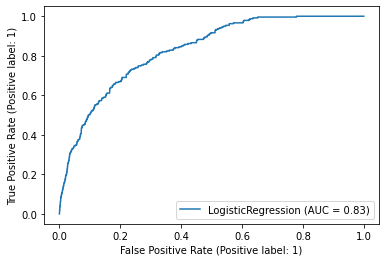

In [595]:
from sklearn import metrics
metrics.plot_roc_curve(logistic, X_test, y_test) 

In [596]:
#pip install kds

In [597]:
#using model for prediction
import kds

y_prob = logistic.predict_proba(X_7244[selectedFeatures_pearson])

metrics = kds.metrics.decile_table(y_7244, y_prob[:,1])

metrics.to_csv(r'./metrics1.csv')

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

In [598]:
#libraries
import matplotlib.pyplot as plt
import scikitplot as skplt

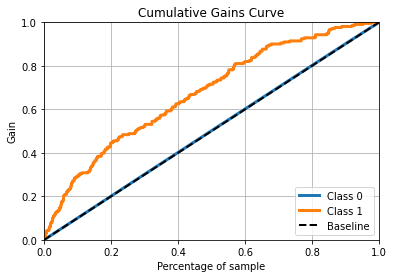

In [599]:
#plotting cumulative gain
skplt.metrics.plot_cumulative_gain(y_7244, y_prob)
plt.show()

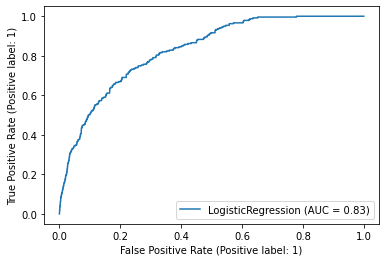

In [600]:
#plotting roc
from sklearn import metrics
metrics.plot_roc_curve(logistic, X_test, y_test)

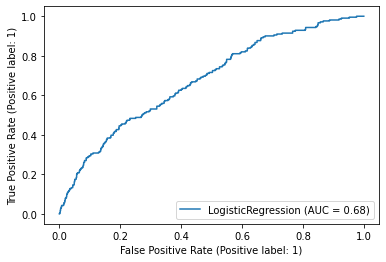

In [601]:
metrics.plot_roc_curve(logistic, X_7244[selectedFeatures_pearson], y_7244)

In [602]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(y_7244).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(X_7244[selectedFeatures_pearson]))[1]
    lifts[model] = lift(dataSet = data, actuals = "has_contributed", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "has_contributed", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "has_contributed", probability = "proba "+str(model))

Text(0.5, 1.0, 'Lift')

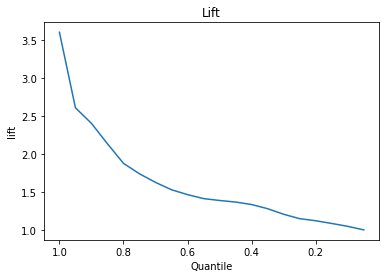

In [603]:
# Plotting the lift and quantile
pyplot.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
pyplot.gca().invert_xaxis()
pyplot.xlabel("Quantile")
pyplot.ylabel("lift")
pyplot.title("Lift")

<Figure size 1440x2160 with 0 Axes>

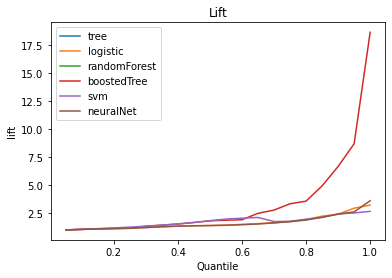

<Figure size 1440x2160 with 0 Axes>

In [604]:
for model in models:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    plt.gca().invert_xaxis()
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend(lifts[model])
    plt.legend(lifts.keys())
plt.figure(figsize=(20,30))

# NEW CAMPAIGN

In [605]:
#reading in the data
selection  = pd.read_csv('../dsc_data/new_campaign_selection.csv', sep=',')
selection.head()

,donorID
0,134242
1,126503
2,104392
3,105905
4,120506


In [606]:
len(selection)

26522

In [607]:
#selecting the date : 15th December 2020
start = datetime.datetime(year=2020, month=12, day=15)

gifts_new = gifts[(gifts["date"] < start)]

len(gifts_new)

216594

In [608]:
basetable_final = gifts_new.groupby(["donorID"])["amount"].agg(['sum', 'count']).reset_index()
basetable_final.head()

,donorID,sum,count
0,100001,178.49,12
1,100002,20.00,1
2,100003,46.00,12
3,100004,716.22,26
4,100005,24.96,5


In [609]:
#Setting the timeline for amount donated in the last one year
end_target =  datetime.datetime(year= 2020, month = 12, day = 15)
start_target =  datetime.datetime(year= 2019, month = 12, day = 15)

#Calculating the amount donated in the last two years
gifts_1y = gifts_new[(gifts_new['date'] <= end_target) & (gifts_new["date"] >= start_target)]

# Group and sum donations by donor
gifts_1y_camp = gifts_1y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_1y_camp.columns = ["donorID", "1y_camp_count", "1y_camp_sum"]

In [610]:
#Merging gifts_1y to basetable_final
basetable_final = basetable_final.merge(gifts_1y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 44699
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44700 non-null  int64  
 1   sum            44700 non-null  float64
 2   count          44700 non-null  int64  
 3   1y_camp_count  126 non-null    float64
 4   1y_camp_sum    126 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 2.0 MB


In [611]:
#Setting the timeline for amount donated in the last two years
end_target =  datetime.datetime(year= 2019, month = 12, day = 15)
start_target =  datetime.datetime(year= 2017, month = 12, day = 15)

#Calculating the amount donated in the last two years
gifts_2y = gifts_new[(gifts_new['date'] <= end_target) & (gifts_new["date"] >= start_target)]

# Group and sum donations by donor
gifts_2y_camp = gifts_2y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_2y_camp.columns = ["donorID", "2y_camp_count", "2y_camp_sum"]

In [612]:
#Merging gifts_2y to basetable_final
basetable_final = basetable_final.merge(gifts_2y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 44699
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44700 non-null  int64  
 1   sum            44700 non-null  float64
 2   count          44700 non-null  int64  
 3   1y_camp_count  126 non-null    float64
 4   1y_camp_sum    126 non-null    float64
 5   2y_camp_count  5580 non-null   float64
 6   2y_camp_sum    5580 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 2.7 MB


In [613]:
#Setting the timeline for amount donated in the last four years
end_target =  datetime.datetime(year= 2017, month = 12, day = 15)
start_target =  datetime.datetime(year= 2013, month = 12, day = 15)

#Calculating the amount donated in the last four years
gifts_4y = gifts_new[(gifts_new['date'] <= end_target) & (gifts_new["date"] >= start_target)]

# Group and sum donations by donor
gifts_4y_camp = gifts_4y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_4y_camp.columns = ["donorID", "4y_camp_count", "4y_camp_sum"]

In [614]:
#Merging gifts_4y to basetable_final
basetable_final = basetable_final.merge(gifts_4y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 44699
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44700 non-null  int64  
 1   sum            44700 non-null  float64
 2   count          44700 non-null  int64  
 3   1y_camp_count  126 non-null    float64
 4   1y_camp_sum    126 non-null    float64
 5   2y_camp_count  5580 non-null   float64
 6   2y_camp_sum    5580 non-null   float64
 7   4y_camp_count  18483 non-null  float64
 8   4y_camp_sum    18483 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 3.4 MB


In [615]:
#Setting the timeline for amount donated in the last six years
end_target =  datetime.datetime(year= 2013, month = 12, day = 15)
start_target =  datetime.datetime(year= 2007, month = 12, day = 15)

#Calculating the amount donated in the last six years
gifts_6y = gifts_new[(gifts_new['date'] <= end_target) & (gifts_new["date"] >= start_target)]

# Group and sum donations by donor
gifts_6y_camp = gifts_6y.groupby("donorID")['amount'].agg(['count', 'sum']).reset_index()
gifts_6y_camp.columns = ["donorID", "6y_camp_count", "6y_camp_sum"]

In [616]:
#Merging gifts_6y to basetable_final
basetable_final = basetable_final.merge(gifts_6y_camp, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 44699
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   donorID        44700 non-null  int64  
 1   sum            44700 non-null  float64
 2   count          44700 non-null  int64  
 3   1y_camp_count  126 non-null    float64
 4   1y_camp_sum    126 non-null    float64
 5   2y_camp_count  5580 non-null   float64
 6   2y_camp_sum    5580 non-null   float64
 7   4y_camp_count  18483 non-null  float64
 8   4y_camp_sum    18483 non-null  float64
 9   6y_camp_count  30536 non-null  float64
 10  6y_camp_sum    30536 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.1 MB


In [617]:
#calculating the gift first and last year for donors
gift_first_last_year = gifts.groupby('donorID').agg(gift_first_year = ('gift_year',min), gift_last_year = ('gift_year',max)).reset_index()

In [618]:
#Calculating the last and first period of donations by donors
gift_first_last_year['gift_first_year'] = 2020 - gift_first_last_year['gift_first_year']
gift_first_last_year['gift_last_year'] = gift_first_last_year['gift_last_year']
basetable_final =  basetable_final.merge(gift_first_last_year, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 44699
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   donorID          44700 non-null  int64  
 1   sum              44700 non-null  float64
 2   count            44700 non-null  int64  
 3   1y_camp_count    126 non-null    float64
 4   1y_camp_sum      126 non-null    float64
 5   2y_camp_count    5580 non-null   float64
 6   2y_camp_sum      5580 non-null   float64
 7   4y_camp_count    18483 non-null  float64
 8   4y_camp_sum      18483 non-null  float64
 9   6y_camp_count    30536 non-null  float64
 10  6y_camp_sum      30536 non-null  float64
 11  gift_first_year  44700 non-null  int64  
 12  gift_last_year   44700 non-null  int64  
dtypes: float64(9), int64(4)
memory usage: 4.8 MB


In [619]:
#creating new variables
gifts_total = gifts_campaign.groupby('donorID') \
                        .agg(total_camp_count = ('campaignID','count'), total_camp_amt = ('amount','sum'), \
                            total_camp_min_amt = ('amount','min'), total_camp_max_amt = ('amount','max')).reset_index()
gifts_total['total_amt_greater_30'] = np.where(gifts_total['total_camp_max_amt'] > 35, 1,0)
gifts_total['total_amt_greater_60'] = np.where(gifts_total['total_camp_max_amt'] > 60, 1,0)
gifts_total['total_amt_greater_100'] = np.where(gifts_total['total_camp_max_amt'] > 100, 1,0)
basetable_final =  basetable_final.merge(gifts_total, left_on = 'donorID', right_on = 'donorID', how='left')

basetable_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 44699
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                44700 non-null  int64  
 1   sum                    44700 non-null  float64
 2   count                  44700 non-null  int64  
 3   1y_camp_count          126 non-null    float64
 4   1y_camp_sum            126 non-null    float64
 5   2y_camp_count          5580 non-null   float64
 6   2y_camp_sum            5580 non-null   float64
 7   4y_camp_count          18483 non-null  float64
 8   4y_camp_sum            18483 non-null  float64
 9   6y_camp_count          30536 non-null  float64
 10  6y_camp_sum            30536 non-null  float64
 11  gift_first_year        44700 non-null  int64  
 12  gift_last_year         44700 non-null  int64  
 13  total_camp_count       44686 non-null  float64
 14  total_camp_amt         44686 non-null  float64
 15  to

In [620]:
#Merging donors with basetable_trait
basetable_final = basetable_final.merge(donors, left_on = 'donorID', right_on = 'donorID', how='left')
basetable_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 44699
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                44700 non-null  int64  
 1   sum                    44700 non-null  float64
 2   count                  44700 non-null  int64  
 3   1y_camp_count          126 non-null    float64
 4   1y_camp_sum            126 non-null    float64
 5   2y_camp_count          5580 non-null   float64
 6   2y_camp_sum            5580 non-null   float64
 7   4y_camp_count          18483 non-null  float64
 8   4y_camp_sum            18483 non-null  float64
 9   6y_camp_count          30536 non-null  float64
 10  6y_camp_sum            30536 non-null  float64
 11  gift_first_year        44700 non-null  int64  
 12  gift_last_year         44700 non-null  int64  
 13  total_camp_count       44686 non-null  float64
 14  total_camp_amt         44686 non-null  float64
 15  to

In [621]:
#Merging basetable_final and selection
basetable_final = pd.merge(selection, basetable_final, on = "donorID", how = "left")
len(basetable_final)
basetable_final.head(2)

,donorID,sum,count,1y_camp_count,1y_camp_sum,2y_camp_count,2y_camp_sum,4y_camp_count,4y_camp_sum,6y_camp_count,...,Antwerp,Brussels,Walloon Brabant,West Flanders,East Flanders,Liege,Luxembourg,Namur,Hainaut,Limburg
0,134242,30.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,126503,50.0,1.0,NaN,NaN,NaN,NaN,1.0,50.0,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [622]:
#replacing missing values by 0
basetable_final["sum"] = basetable_final["sum"].replace(np.nan, 0)
basetable_final["count"] = basetable_final["count"].replace(np.nan, 0)
basetable_final["1y_camp_count"] = basetable_final["1y_camp_count"].replace(np.nan, 0)
basetable_final["1y_camp_sum"] = basetable_final["1y_camp_sum"].replace(np.nan, 0)
basetable_final["2y_camp_count"] = basetable_final["2y_camp_count"].replace(np.nan, 0)
basetable_final["2y_camp_sum"] = basetable_final["2y_camp_sum"].replace(np.nan, 0)
basetable_final["4y_camp_count"] = basetable_final["4y_camp_count"].replace(np.nan, 0)
basetable_final["4y_camp_sum"] = basetable_final["4y_camp_sum"].replace(np.nan, 0)
basetable_final["6y_camp_count"] = basetable_final["6y_camp_count"].replace(np.nan, 0)
basetable_final["6y_camp_sum"] = basetable_final["6y_camp_sum"].replace(np.nan, 0)
basetable_final["gift_first_year"] = basetable_final["gift_first_year"].replace(np.nan, 0)
basetable_final["gift_last_year"] = basetable_final["gift_last_year"].replace(np.nan, 0)
basetable_final["total_camp_count"] = basetable_final["total_camp_count"].replace(np.nan, 0)
basetable_final["total_camp_amt"] = basetable_final["total_camp_amt"].replace(np.nan, 0)
basetable_final["total_camp_min_amt"] = basetable_final["total_camp_min_amt"].replace(np.nan, 0)
basetable_final["total_camp_max_amt"] = basetable_final["total_camp_max_amt"].replace(np.nan, 0)
basetable_final["total_amt_greater_30"] = basetable_final["total_amt_greater_30"].replace(np.nan, 0)
basetable_final["total_amt_greater_60"] = basetable_final["total_amt_greater_60"].replace(np.nan, 0)
basetable_final["total_amt_greater_100"] = basetable_final["total_amt_greater_100"].replace(np.nan, 0)

In [623]:
#filling nas with  missing 
basetable_final['region'] = basetable_final['region'].fillna('missing')

In [624]:
#checking for unique values in column
basetable_final['region'].unique()

array(['Flanders', 'Wallonia', 'Brussels', 'missing'], dtype=object)

In [625]:
basetable_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26522 entries, 0 to 26521
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   donorID                26522 non-null  int64  
 1   sum                    26522 non-null  float64
 2   count                  26522 non-null  float64
 3   1y_camp_count          26522 non-null  float64
 4   1y_camp_sum            26522 non-null  float64
 5   2y_camp_count          26522 non-null  float64
 6   2y_camp_sum            26522 non-null  float64
 7   4y_camp_count          26522 non-null  float64
 8   4y_camp_sum            26522 non-null  float64
 9   6y_camp_count          26522 non-null  float64
 10  6y_camp_sum            26522 non-null  float64
 11  gift_first_year        26522 non-null  float64
 12  gift_last_year         26522 non-null  float64
 13  total_camp_count       26522 non-null  float64
 14  total_camp_amt         26522 non-null  float64
 15  to

In [626]:
#writing out the data into a csv file
basetable_final.to_csv('../dsc_data/basetable_finaldata.csv')

In [627]:
#selected features
selectedFeatures_pearson

['4y_camp_sum',
 'gift_last_year',
 'total_amt_greater_30',
 'total_amt_greater_60',
 'age',
 'Gender_M',
 'Gender_F']

In [628]:
#Preprocessing before modelling
le = preprocessing.LabelEncoder()
basetable_final['region']  = le.fit_transform(basetable_final['region'])
basetable_final = basetable_final.fillna(0)
basetable_final.drop('donorID', axis=1, inplace = True)

In [629]:
#applying our logistic regression model on the final basetable
y_pred_7362 = models['logistic'].predict_proba(basetable_final[selectedFeatures_pearson])

In [630]:
#applying it on our selected features
y_pred_7362_selected_features = models['logistic'].predict_proba(basetable_final[selectedFeatures_pearson])

In [631]:
#checking the sum of the predicted donors
y_pred_7362.sum()

26522.000000000004

In [632]:
#checking the predicted values
y_pred_7362

array([[0.99581145, 0.00418855],
       [0.95923171, 0.04076829],
       [0.93705005, 0.06294995],
       ...,
       [0.99261748, 0.00738252],
       [0.9972809 , 0.0027191 ],
       [0.99650718, 0.00349282]])

In [633]:
#setting threshold for predicted value in other to get the predictions
pred = np.where(pd.DataFrame(y_pred_7362_selected_features)[1]>.2, 1, 0)

In [635]:
#checking the values after threshold has been set
pred

array([0, 0, 0, ..., 0, 0, 0])

In [636]:
#feeding in predicted values 
y_pred_7362 = pd.DataFrame(pred)

In [637]:
#checking the confusion matrix distribution of predictions
confusion_matrix(y_pred_7362, pred)

array([[26184,     0],
       [    0,   338]], dtype=int64)

In [638]:
#checking the length of the new predictiona
len(y_pred_7362)

26522

In [639]:
#matching and creating the values of prediction in the actual dataset
selection['Predictions'] = y_pred_7362

In [640]:
selection

,donorID,Predictions
0,134242,0
1,126503,0
2,104392,0
3,105905,0
4,120506,0
...,...,...
26517,114719,0
26518,134824,0
26519,143259,0
26520,123936,0


In [641]:
selection["predictions"] = y_pred_7362

In [642]:
selection.groupby("predictions")["donorID"].count()

predictions
0    26184
1      338
Name: donorID, dtype: int64

In [643]:
selection.to_csv(r'./selection_7362.csv')